In [3]:
%matplotlib notebook

In [4]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pymap3d as pm
import datetime
import pandas as pd
from spacetrack import SpaceTrackClient
from scipy.optimize import root
from mpl_toolkits.mplot3d import Axes3D

![title](contents/Perifocal.png)

![title](contents/Perifocal2ECI.png)

In [5]:
def perifocal2eci(Ω, i, ω):
    a = np.array([[np.cos(Ω), -np.sin(Ω), 0], [np.sin(Ω), np.cos(Ω), 0], [0, 0, 1]])
    b = np.array([[1, 0, 0], [0, np.cos(i), -np.sin(i)], [0, np.sin(i), np.cos(i)]])
    c = np.array([[np.cos(ω), -np.sin(ω), 0], [np.sin(ω), np.cos(ω), 0], [0, 0, 1]])
    total = np.dot(np.dot(a, b),c)
    return total

![title](contents/matrix.jpg)

In [6]:
def ecef2eci(x,y,z,time):
    x_eci, y_eci, z_eci = pm.ecef2eci(x, y, z, time=time, use_astropy=True)
    return x_eci, y_eci, z_eci 

https://ru.wikipedia.org/wiki/%D0%AD%D0%BB%D0%BB%D0%B8%D0%BF%D1%81

In [7]:
def find_sat(i, Ω, e, ω, M, n, s, time, sat_t):
    position_perifocal = []
    position_eci = []
    for elem in time:
        Δt = (elem - sat_t).seconds / 3600 / 24
        # средняя аномалия для выбранной даты
        M_average = M /360 + (n * Δt)
        M_average = M_average - math.floor(M_average)
        # E - e sinE = M
        E = root(lambda E: E - e * np.cos(2 * np.pi * E) - M_average, 0).x[0]
        E = 2 * np.pi * E   # перевод в радианы
        # находим истинную аномалию
        v = 2 * np.arctan(np.sqrt((1+e)/(1-e)) * np.tan(E/2))
        # грав. параметр земли км^3/день^2
        μ = 2.9755363405824e15
        # большая полуось орбиты в км
        a = np.cbrt(μ / ((2 * np.pi * n) ** 2))  
        # фокальный параметр
        p = a * (1 - e**2)
        # мгновенное геоцентрическое растояние в км
        r = p / (1 + e * np.cos(v))
        x_perifocal = r * np.cos(v)
        y_perifocal = r * np.sin(v)
        z_perifocal = 0
        position_perifocal = [[x_perifocal],[y_perifocal],[ z_perifocal]]
        position_eci.append(np.dot(perifocal2eci(Ω, i, ω),position_perifocal))
    # returns vec (3,1)
    return position_eci

getting and parsing TLE data:
https://gis-lab.info/qa/python-orbital-tracks.html

In [8]:
sat_id = {15: 25338, 16: 26536, 17: 27453, 18: 28654, 19: 33591}
# getting TLE data #
n = int(input("NOAA:"))
USERNAME = "radmir-daminov@mail.ru"
PASSWORD = "!9vehaNGZrVuFqj"
st = SpaceTrackClient(identity=USERNAME, password=PASSWORD)
data = st.tle_latest(norad_cat_id=sat_id[n], orderby='epoch desc', limit=1, format='tle')

NOAA:19


In [25]:
start_lesson = datetime.datetime(2020, 10, 6, 21, 0)
end_lesson = datetime.datetime(2020, 10, 7, 9, 30)
date_generated = pd.date_range(start=start_lesson, end=end_lesson, freq='0.1min')

In [26]:
# parsing TLE data #
i = float(data[78:86])  # Наклонение в градусах
Ω = float(data[87:96])  # Долгота восходящего узла в градусах
e = float("0." + data[96:103])  # Эксцентриситет
ω = float(data[104:112])  # Аргумент перицентра в градусах
M = float(data[113:121])  # Средняя аномалия в градусах
n = float(data[122:133])  # Частота обращения (оборотов в день) (среднее движение) [виток/день]
s = int(86400*float("0." + data[24:32]))
sat_t = datetime.datetime(int("20" + data[18:20]), 1, 1) + datetime.timedelta(days=int(data[20:23]) - 1) + datetime.timedelta(seconds=s)  # Время эпохи

In [27]:
Re = 6378.137
Rp = 6356.752

#LK
lat = np.radians(55.93026296)
lon = np.radians(37.51819789)
alt = 0.2

R = 1 / np.sqrt( (np.cos(lat)/Re)**2 + (np.sin(lat)/Rp)**2 ) + alt

LK_x = R * np.cos(lon) * np.cos(lat)
LK_y = R * np.sin(lon) * np.cos(lat)
LK_z = R * np.sin(lat)

In [28]:
position = find_sat(i, Ω, e, ω, M, n, s, date_generated, sat_t)
x_pos = []
y_pos = []
z_pos = []
for elem in position:
    x_pos.append(elem[0])
    y_pos.append(elem[1])
    z_pos.append(elem[2])

![title](contents/AZandELEV.png)

In [35]:
elevations1 = []
elevations = []
azimuths = []
LK_x_eci = []
LK_y_eci = []
LK_z_eci = []
for i in range(len(date_generated)):
    r = []
    x_eci,y_eci,z_eci = pm.ecef2eci(LK_x,LK_y,LK_z,date_generated[i])
    LK_x_eci.append(x_eci[0])
    LK_y_eci.append(y_eci[0])
    LK_z_eci.append(z_eci[0])
    r.append(position[i][0] - x_eci[0])
    r.append(position[i][1] - y_eci[0])
    r.append(position[i][2] - z_eci[0])
    ###### finding the azimuth
    r_LK = [x_eci[0],y_eci[0],z_eci[0]]
    ρ = [x_eci[0],y_eci[0],0]
    β = -np.sign(np.arcsin(y_eci[0] / np.linalg.norm(ρ))) * np.arccos(x_eci[0]/ np.linalg.norm(ρ))
    α = np.arcsin(z_eci[0]/np.linalg.norm(r_LK))
    
    tmp_x = np.cos(β) * position[i][0] - np.sin(β) * position[i][1]
    tmp_y = np.sin(β) * position[i][0] + np.cos(β) * position[i][1]
    tmp_z = position[i][2]
    
    arg = α - np.pi/2
    new_x = np.sin(arg) * tmp_z + np.cos(arg) * tmp_x
    new_y = tmp_y
    new_z = np.cos(arg) * tmp_z - np.sin(arg) * tmp_x
    ρ = [new_x,new_y,0]
    new_z -= 6371
    azimuth = np.sign(new_y) * np.arccos(new_x/np.linalg.norm(ρ)) - np.pi/2  # new longtitude
    ######
    distance = np.linalg.norm(r)
    Z = np.degrees(np.arcsin(new_z/distance) if np.abs(new_z/distance) < 1 else np.arcsin(int(new_z/distance)))
    ##Z = np.arccos((r[0]/distance * np.cos(lat) * np.cos(lon)) + (r[1]/distance * np.cos(lat) * np.sin(lon)) + (r[2]/distance * np.sin(lat)))
    ##Z = 90 - Z * 180/math.pi
    elevations.append(Z)
    if Z > 0:
        elevations1.append(90 - Z)
        azimuths.append(azimuth)

<IPython.core.display.Javascript object>


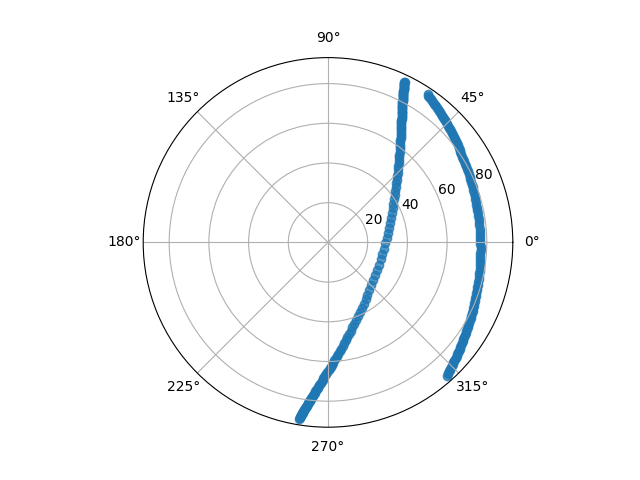

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
c = ax.scatter(azimuths, elevations1, alpha=0.75)

<IPython.core.display.Javascript object>


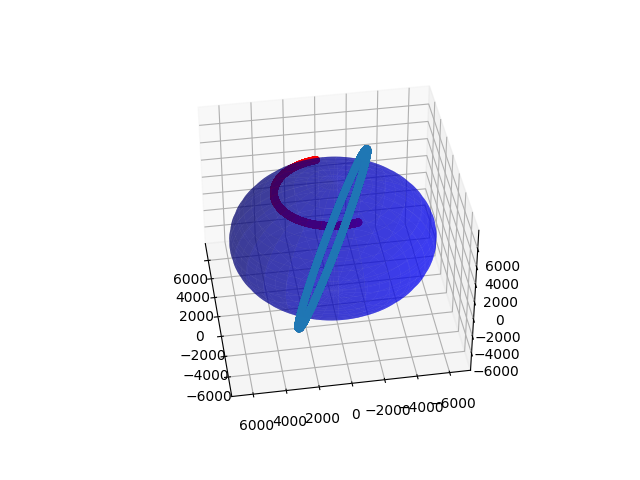

In [31]:
# Earth
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

earth_x = R * np.outer(np.cos(u), np.sin(v))
earth_y = R * np.outer(np.sin(u), np.sin(v))
earth_z = R * np.outer(np.ones(np.size(u)), np.cos(v))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_pos, y_pos, z_pos)
ax.plot_surface(earth_x, earth_y, earth_z,  rstride=4, cstride=4, color='b', linewidth=0, alpha=0.5)
ax.scatter(LK_x_eci, LK_y_eci, LK_z_eci,color="red") 

In [32]:
edge = 10 #deg
isOnline = False
for i in range(len(position)):
    if elevations[i] > edge and not isOnline:
        print("session start:",date_generated[i],elevations[i])
        isOnline = True
    elif elevations[i] < edge and isOnline:
        print("session end:",date_generated[i],elevations[i])
        print()
        isOnline = False

session start: 2020-10-07 06:21:18 [10.14513614]
session end: 2020-10-07 06:26:24 [9.9325324]

session start: 2020-10-07 08:00:42 [10.30394994]
session end: 2020-10-07 08:11:54 [9.62900041]

